In [1]:
from pycaret.regression import *
import xarray as xr
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, LogNorm

import warnings

from scipy import stats
pd.set_option('display.max_columns', None)
# Suppress all warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import shap

In [2]:
# Example colormaps
cmap1 = plt.cm.Blues
cmap2 = plt.cm.plasma
cmap3 = plt.cm.plasma

colors1 = cmap1(np.linspace(0.01, 1,250))
colors2 = cmap2(np.linspace(0.2, 1, 400))
colors3 = cmap3(np.linspace(0.8, 1, 100))

colors = np.vstack((colors1, colors2))

colors_pd = pd.DataFrame(colors)
colors_pd = colors_pd.rolling(window = 250, min_periods = 1).mean()
x = colors_pd.values
colors = np.vstack((colors_pd.values, colors3))
colors_pd = pd.DataFrame(colors)
colors_pd = colors_pd.rolling(window = 50, min_periods = 1).mean()
x = colors_pd.values
# colors3 = colors_pd.values

blended_cmap = LinearSegmentedColormap.from_list('blended_cmap', x)

def subset_training(train_df):

    deep = train_df[(train_df.sd_insitu>3)]
    mid = train_df[(train_df.sd_insitu>1)&(train_df.sd_insitu<3)]
    shallow = train_df[(train_df.sd_insitu<1)&(train_df.sd_insitu>0)]
    zero = train_df[(train_df.sd_insitu==0)]
    
    nn = int(len(mid))
    new_mid = mid.sample(frac=0.75)
    new_shallow = shallow.sample(frac = 0.5)
    new_zero = zero.sample(frac = 0.5)
    data_subset = pd.concat([deep, mid, shallow, new_zero])

    return data_subset
 

In [21]:
with open('/staging/leuven/stg_00024/OUTPUT/devond/S1_ML_project/training_testing/training_data.p', 'rb') as fp:
    all_data = pickle.load(fp) 
    
with open('/staging/leuven/stg_00024/OUTPUT/devond/S1_ML_project/training_testing/map_training_data.p', 'rb') as fp:
    all_data_map = pickle.load(fp) 

all_data = subset_training(all_data)
all_data = pd.concat([all_data, all_data_map])

all_data[(all_data.sc_percum<0.25)&(all_data.sd_insitu>0.5)] = np.nan
all_data[(all_data.sc_percum>5)&(all_data.sd_insitu==0)] = np.nan
all_data = all_data.dropna(how = 'all')


In [31]:
numeric_features = ['elevation','slope','aspect','fcf','tpi', 'DayOfSeason', 'sc_percum', 'lia', 'sc_per', 'cr_scaled', 'vv_scaled']
categorical_features = ['snowclass']

all_features = numeric_features.copy()
all_features.extend(categorical_features)
all_features.append('sd_insitu')
all_features.append('fold')

RegressionExperiment()
all_pred = pd.DataFrame()

In [20]:
test = all_data[all_data.fold==3]
test = test.reset_index()
test = test.drop(labels = 'index', axis = 1)

train = all_data[all_data.fold!=3]
train = train.reset_index()
train = train.drop(labels = 'index', axis = 1)
    
test_features = test[all_features].dropna().reset_index(drop = True)
train_features = train[all_features].dropna().reset_index(drop = True)
train_subset = subset_training(train_features)
train_subset = train_subset.reset_index(drop=True)

regr = setup(train_subset, test_data = test_features, target = 'sd_insitu', ignore_features = ['fold', 'sd_hans'], numeric_features = numeric_features, categorical_features = categorical_features,\
    numeric_imputation='drop',index = False, normalize = True, fold_strategy = 'groupkfold', fold_groups = 'fold', fold = 4, session_id = 42, remove_outliers = True, verbose = False)

compare_models()

KeyboardInterrupt: 

In [ ]:
xgboost = create_model('xgboost')
et = create_model('et')
catboost = create_model('catboost')

tune_model(xgboost, n_iter = 50)
tune_model(catboost, n_iter = 50)

In [32]:
for tfold in [1,2,3,4,5]:
    print(tfold)
    test = all_data[all_data.fold==tfold]#.dropna()
    test_features = test[all_features].reset_index(drop = True)

    
    train = all_data[all_data.fold!=tfold]
    train_features = train[all_features].reset_index(drop = True)
    print(len(train), len(test))

    regr = setup(train_features, test_data = test_features, target = 'sd_insitu', ignore_features = ['fold', 'sd_hans'], numeric_features = numeric_features, categorical_features = categorical_features,\
              numeric_imputation='drop',index = False, normalize = True, fold_strategy = 'groupkfold', fold_groups = 'fold', fold = 4, session_id = 42, remove_outliers = True, verbose = False)
    
    mod = create_model('xgboost')
    tuned_mod = tune_model(mod, n_iter = 50, optimize = 'MSE')

    pred = predict_model(tuned_mod, data = test)
    all_pred = pd.concat([all_pred, pred])

1
8745 1160


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3948,0.3136,0.5600,-0.1938,0.1151,0.1029
1,0.4536,0.3449,0.5873,-0.4971,0.1225,0.1274
2,0.5620,0.6674,0.8170,-0.1559,0.1601,0.1374
3,0.5049,0.5068,0.7119,-0.9882,0.1428,0.1352
Mean,0.4788,0.4582,0.6690,-0.4587,0.1351,0.1257
Std,0.0618,0.1413,0.1028,0.3331,0.0176,0.0137


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3918,0.2641,0.5139,-0.0053,0.1054,0.1071
1,0.3832,0.2374,0.4872,-0.0302,0.1017,0.1075
2,0.5350,0.5991,0.7740,-0.0375,0.1479,0.1302
3,0.4047,0.2505,0.5005,0.0171,0.1043,0.1097
Mean,0.4287,0.3378,0.5689,-0.0140,0.1148,0.1136
Std,0.0619,0.1512,0.1188,0.0215,0.0192,0.0096


Fitting 4 folds for each of 50 candidates, totalling 200 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.3663,0.1822,0.4268,0.0036,0.0920,0.1040


2
4999 4906


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4132,0.3105,0.5572,-0.3475,0.1172,0.1116
1,0.4569,0.4011,0.6333,-1.1941,0.1300,0.1256
2,0.5561,0.6893,0.8302,-0.1937,0.1615,0.1319
3,0.4238,0.3313,0.5755,-0.2996,0.1214,0.1107
Mean,0.4625,0.4330,0.6491,-0.5087,0.1325,0.1200
Std,0.0564,0.1517,0.1083,0.3996,0.0174,0.0091


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3896,0.2405,0.4904,-0.0440,0.1026,0.1097
1,0.3671,0.1817,0.4262,0.0062,0.0922,0.1050
2,0.5312,0.5999,0.7745,-0.0390,0.1479,0.1287
3,0.4047,0.2528,0.5028,0.0081,0.1046,0.1093
Mean,0.4232,0.3187,0.5485,-0.0172,0.1118,0.1132
Std,0.0638,0.1646,0.1337,0.0244,0.0214,0.0091


Fitting 4 folds for each of 50 candidates, totalling 200 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.3847,0.2629,0.5127,-0.0011,0.1048,0.1043


3
8881 1024


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3928,0.3104,0.5571,-0.1815,0.1146,0.1022
1,0.4972,0.3892,0.6238,-0.6891,0.1305,0.1403
2,0.4868,0.4370,0.6611,-1.3906,0.1387,0.1345
3,0.5579,0.6891,0.8301,-0.1933,0.1623,0.1331
Mean,0.4837,0.4564,0.6680,-0.6136,0.1365,0.1275
Std,0.0591,0.1417,0.1007,0.4931,0.0172,0.0148


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3864,0.2631,0.5130,-0.0018,0.1049,0.1050
1,0.3800,0.2356,0.4854,-0.0226,0.1012,0.1063
2,0.3668,0.1825,0.4272,0.0016,0.0921,0.1042
3,0.5349,0.6031,0.7766,-0.0444,0.1484,0.1298
Mean,0.4170,0.3211,0.5505,-0.0168,0.1116,0.1113
Std,0.0684,0.1654,0.1341,0.0184,0.0217,0.0107


Fitting 4 folds for each of 50 candidates, totalling 200 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.4053,0.2553,0.5053,-0.0016,0.1051,0.1093


4
8807 1098


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4103,0.3529,0.5940,-0.3434,0.1228,0.1053
1,0.4631,0.3707,0.6088,-0.6087,0.1261,0.1291
2,0.3727,0.2373,0.4872,-0.2982,0.1042,0.1024
3,0.4284,0.3113,0.5579,-0.2212,0.1172,0.1129
Mean,0.4186,0.3180,0.5620,-0.3679,0.1176,0.1124
Std,0.0326,0.0513,0.0470,0.1458,0.0083,0.0104


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3739,0.2627,0.5126,-0.0002,0.1043,0.1001
1,0.3732,0.2327,0.4824,-0.0101,0.1002,0.1038
2,0.3596,0.1825,0.4272,0.0017,0.0918,0.1012
3,0.3986,0.2556,0.5056,-0.0029,0.1048,0.1065
Mean,0.3763,0.2334,0.4819,-0.0029,0.1003,0.1029
Std,0.0141,0.0314,0.0335,0.0045,0.0052,0.0025


Fitting 4 folds for each of 50 candidates, totalling 200 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.5350,0.6099,0.7810,-0.0563,0.1492,0.1295


5
8188 1717


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4333,0.3667,0.6056,-0.3961,0.1254,0.1142
1,0.5244,0.5046,0.7103,-1.7600,0.1471,0.1467
2,0.5627,0.6975,0.8351,-0.2079,0.1628,0.1363
3,0.4207,0.3032,0.5506,-0.1895,0.1159,0.1108
Mean,0.4853,0.4680,0.6754,-0.6384,0.1378,0.1270
Std,0.0600,0.1512,0.1086,0.6526,0.0183,0.0150


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3960,0.2661,0.5158,-0.0129,0.1059,0.1085
1,0.3703,0.1839,0.4289,-0.0062,0.0928,0.1058
2,0.5375,0.6041,0.7772,-0.0461,0.1486,0.1310
3,0.4063,0.2526,0.5025,0.0092,0.1047,0.1100
Mean,0.4275,0.3267,0.5561,-0.0140,0.1130,0.1139
Std,0.0648,0.1632,0.1319,0.0202,0.0212,0.0100


Fitting 4 folds for each of 50 candidates, totalling 200 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.3799,0.2360,0.4858,-0.0243,0.1012,0.1062


In [33]:
all_pred = all_pred[~np.isnan(all_pred.site)]

MAE ML = 0.46367597579956055 m, R = -0.04356037267666929, slope = -0.0016868383340838966


[Text(0, 3, '3'), Text(0, 4, '4'), Text(0, 5, '5'), Text(0, 6, '6')]

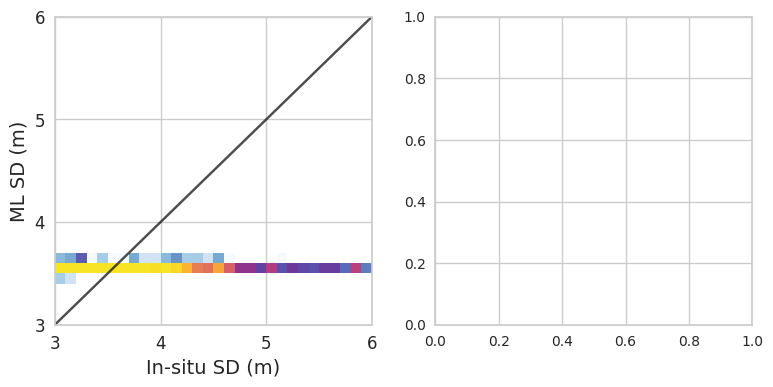

<Figure size 3000x1000 with 0 Axes>

In [38]:
pred = all_pred.copy()#.dropna()
pred.loc[pred.sc_per<0.25, 'prediction_label'] = 0

pred.loc[pred.prediction_label<0, 'prediction_label'] = 0
#pred.loc[pred.prediction_label==0, 'prediction_label'] = np.nan
pred.loc[pred.sd_insitu==0, 'prediction_label'] = np.nan
pred = pred.dropna()

ml = stats.linregress(pred.sd_insitu.values, pred.prediction_label)
#hans = stats.linregress(pred.sd_insitu.values, pred.sd_hans.values)
    
ml_mae = np.abs(pred.sd_insitu.values - pred.prediction_label).mean()
print(f'MAE ML = {ml_mae} m, R = {ml.rvalue}, slope = {ml.slope}')
    
bins = np.arange(0,6.1,0.1)  
fig, ax = plt.subplots(1,1,figsize = (5,5))
    
fig = plt.figure(figsize = (30,10))
im1 = ax[0].hist2d(pred.sd_insitu.values, pred.prediction_label, bins=bins, cmap=blended_cmap, range=[[0, 6], [0, 6]], norm=LogNorm(vmin=1, vmax=100))
ax[0].set_xlim([3,6])
ax[0].set_ylim([3,6])
ax[0].plot([0,6],[0,6], 'k-', alpha = 0.75)
ax[0].set_xlabel('In-situ SD (m)', fontsize = 14)
ax[0].set_ylabel('ML SD (m)', fontsize = 14)
ax[0].set_xticks([3,4,5,6])
ax[0].set_yticks([3,4,5,6])
ax[0].set_xticklabels([3,4,5,6], fontsize = 12)
ax[0].set_yticklabels([3,4,5,6], fontsize = 12)

    

In [8]:
with open('/staging/leuven/stg_00024/OUTPUT/devond/S1_ML_project/OUTPUT/testing_output/predictions_s1_xg.p', 'wb') as fp:
    pickle.dump(all_pred, fp)

In [9]:
train = all_data#[all_data.fold!=1]
train = train.reset_index()
train = train.drop(labels = 'index', axis = 1)
train_features = train[all_features].dropna().reset_index(drop = True)

regr = setup(train_features, target = 'sd_insitu', ignore_features = ['fold'], numeric_features = numeric_features, categorical_features = categorical_features,\
            numeric_imputation='drop',index = False, normalize = True, fold = 5, session_id = 42, remove_outliers = True, verbose = False)
mod = create_model('xgboost')
tuned_mod = tune_model(mod, n_iter = 50, optimize = 'MSE')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2166,0.1084,0.3292,0.8686,0.1473,0.7587
1,0.2164,0.1076,0.3281,0.8715,0.1472,0.8255
2,0.2173,0.1094,0.3307,0.8680,0.1488,0.7847
3,0.2170,0.1094,0.3307,0.8706,0.1480,0.8368
4,0.2169,0.1092,0.3305,0.8680,0.1483,0.7541
Mean,0.2169,0.1088,0.3298,0.8693,0.1479,0.7919
Std,0.0003,0.0007,0.0010,0.0014,0.0006,0.0338


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1892,0.0877,0.2962,0.8937,0.1307,0.6455
1,0.1898,0.0875,0.2959,0.8955,0.1304,0.6890
2,0.1908,0.0895,0.2992,0.8920,0.1330,0.6941
3,0.1902,0.0893,0.2988,0.8943,0.1314,0.7061
4,0.1881,0.0873,0.2954,0.8945,0.1308,0.6284
Mean,0.1896,0.0883,0.2971,0.8940,0.1313,0.6726
Std,0.0009,0.0009,0.0016,0.0012,0.0009,0.0301


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [10]:
final_mod = finalize_model(tuned_mod)
save_model(final_mod, '/staging/leuven/stg_00024/OUTPUT/devond/S1_ML_project/models/final_model_xg')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(transformer=DropImputer(columns=['elevation',
                                                                      'slope',
                                                                      'aspect',
                                                                      'fcf',
                                                                      'tpi',
                                                                      'DayOfSeason',
                                                                      'sc_percum',
                                                                      'lia_100',
                                                                      'sc_per',
                                                                      'cr_100_scaled',
                                                                      'vv_100_scaled']))),
                 (